# Epicenter computation with interrogators data
### Existing methods
In seismic waves propagation, one usually uses triangulation between stations, and the distance is estimated by computing the distance between the $P-$ and $S-$waves. In the particular framework of Acoustic Wave though, only one acoustic wave is propagating through the field. Therefore this method does not work. We aim at solving the epicenter inverse problem for the acoustic wave.

In [1]:
from PyAWD.VectorialAcousticWaveDataset import *
import numpy as np
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
from time import time
from IPython.display import display, Latex

np.random.seed(0)
sns.set_theme()

In [2]:
studied_axis = 0

In [3]:
train = torch.load("../../../local/datasets/AWD/train.pt")
X = [np.array([train.interrogate(i, inter) for inter in train.interrogators]).flatten() for i in range(train.size)]
Y = [train[i][0]/(train.nx/2) for i in range(train.size)]

In [4]:
test = torch.load("../../../local/datasets/AWD/test.pt")
X_test = np.array([np.array([test.interrogate(i, inter) for inter in test.interrogators]).flatten() for i in range(test.size)])
Y_test = np.array([test[i][0]/(test.nx/2) for i in range(test.size)])

## Data presentation

We work with pairs of data under the form:
- Epicenter $(x, y)$
- Wave mesured every $2$ seconds for $10$ seconds.

This follows the hypothese:
- We have an access on the wave amplitude at the given time points for all the spatial points.
  
As an example, sample $0$ starts at this epicenter:

In [5]:
print("Epicenter:", train[0][0])

Epicenter: [-13  56]


and yields this propagation measurement:

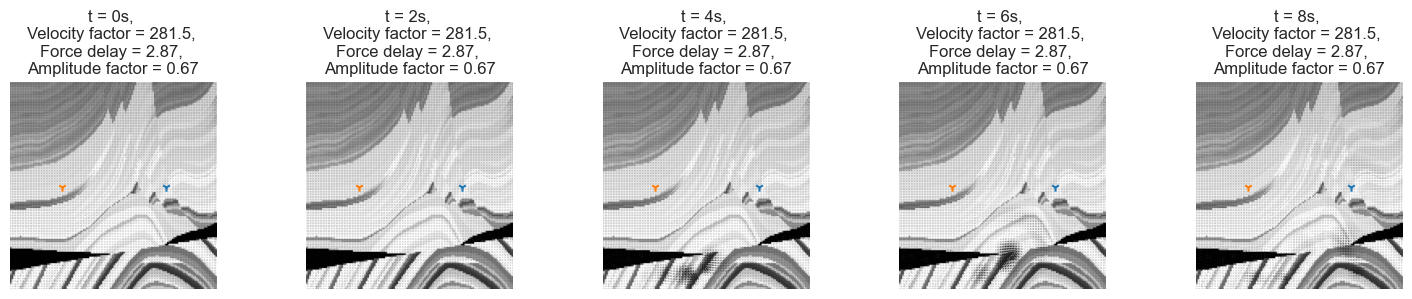

In [6]:
train.plot_item(0)

In [7]:
nmses = {}
times = {}
Y_hat = {}

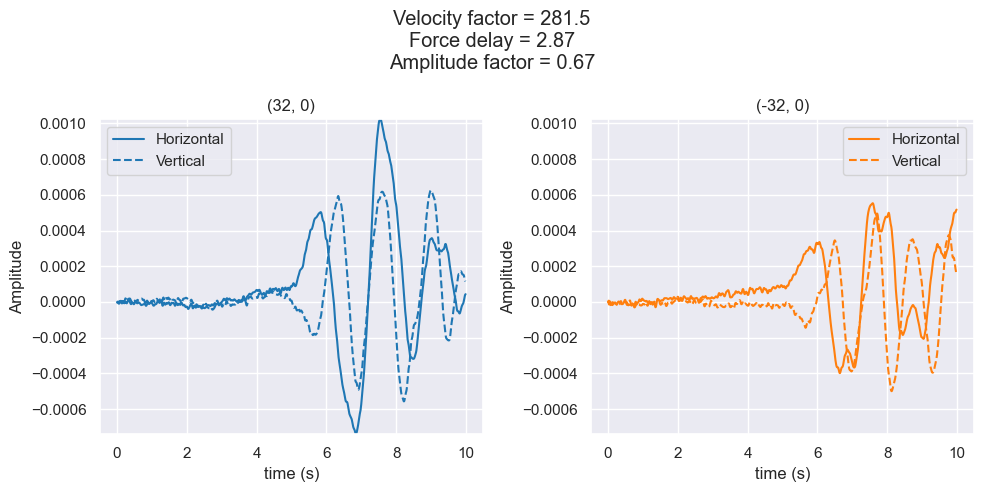

In [8]:
train.plot_interrogators_response(0)
plt.savefig("../Results/example_response.jpg", dpi=250)

## Error function
We use the Normalized Mean Squared Error, given by
$$NMSE(y, \hat{y}) =  \frac{\sum_i(y_i - \hat{y}_i)^2}{|y|\sigma_y}$$

Where $\sigma_y$ is the variance of the target.

In [9]:
def NMSELoss(y, y_hat):
    return np.square(np.subtract(y, y_hat)).mean()/np.var(y)

In [10]:
def experiment(model, X, Y, X_test, Y_test, Y_hat, name):
    t = time()
    m = model.fit(X, Y)
    Y_hat[name] = m.predict(X_test)
    times[name] = time() - t
    nmses[name] = NMSELoss(Y_test, Y_hat[name])
    plt.scatter(Y_test[:, 0], Y_hat[name][:, 0])
    plt.scatter(Y_test[:, 1], Y_hat[name][:, 1])
    plt.legend(["x", "y"])
    plt.xlabel("Expected coordinate")
    plt.ylabel("Computed coordinate")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.title(name)
    plt.savefig("../Results/"+name+".jpg", dpi=250)

## Linear regression

We need to adapt the shape of the testing dataset:

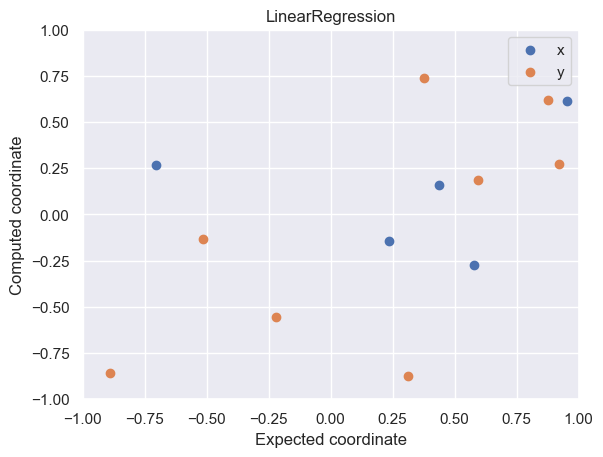

In [11]:
experiment(LinearRegression(), X, Y, X_test, Y_test, Y_hat, "LinearRegression")

## Principal Components Analysis

In [12]:
t = time()
pca = PCA(n_components=64)
pca_model = pca.fit(X)
X_PCA = pca_model.transform(X)
X_test_PCA = pca_model.transform(X_test)
pca_t = time()-t
print("Computation time:", pca_t)

Computation time: 2.9364447593688965


### Linear regression on PCA

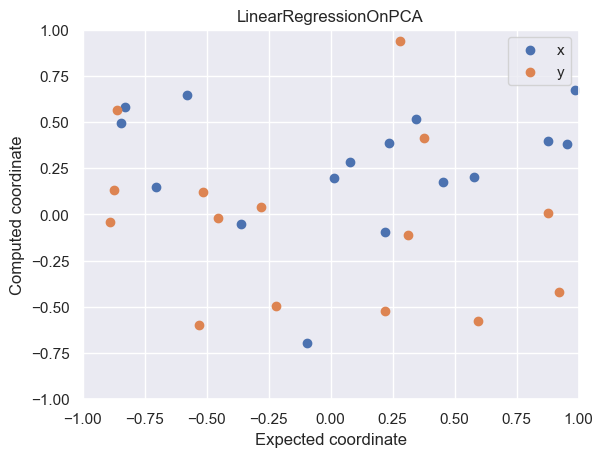

In [13]:
experiment(LinearRegression(), X=X_PCA, Y=Y, X_test=X_test_PCA, Y_test=Y_test, Y_hat=Y_hat, name="LinearRegressionOnPCA")

### Polynomial regression on PCA

In [14]:
polynomial = PolynomialFeatures(degree=2)
X_PCA_polynomial = polynomial.fit_transform(X_PCA)
X_test_PCA_polynomial = polynomial.fit_transform(X_test_PCA)

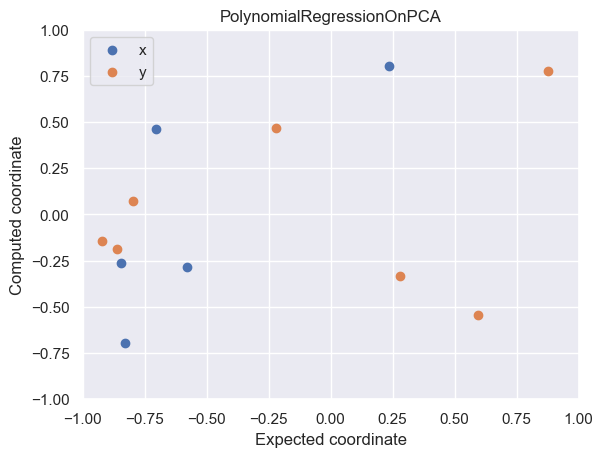

In [15]:
experiment(LinearRegression(), X=X_PCA_polynomial, Y=Y, X_test=X_test_PCA_polynomial, Y_test=Y_test, Y_hat=Y_hat, name="PolynomialRegressionOnPCA")

## LASSO

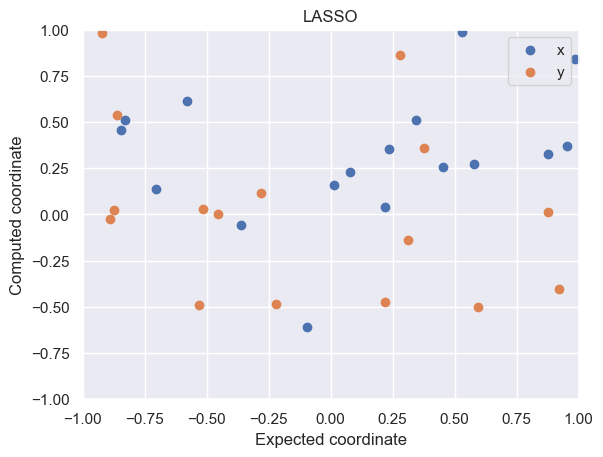

In [16]:
experiment(Lasso(alpha=0.00001, max_iter=25000), X=X_PCA, Y=Y, X_test=X_test_PCA, Y_test=Y_test, Y_hat=Y_hat, name="LASSO")

## Average of all predictions

average = [0 for _ in range(Y_test.shape[0])]
for model in Y_hat:
    for i in range(len(Y_hat[model])):
        average[i] += Y_hat[model][i]
for i in range(len(average)):
    average[i] /= len(Y_hat)

Y_hat["Average"] = average
average_error = NMSELoss(Y_test, Y_test-Y_hat["Average"])
print("NMSE:", average_error)
nmses["Average"] = average_error

plt.scatter(Y_test, Y_hat["Average"] )
plt.xlabel("Expected X coordinate")
plt.ylabel("Computed X coordinate")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Average")
plt.savefig("../Results/Average"+str(studied_axis)+".jpg", dpi=250)

## Results

## Normalized Mean Squared Error for each model

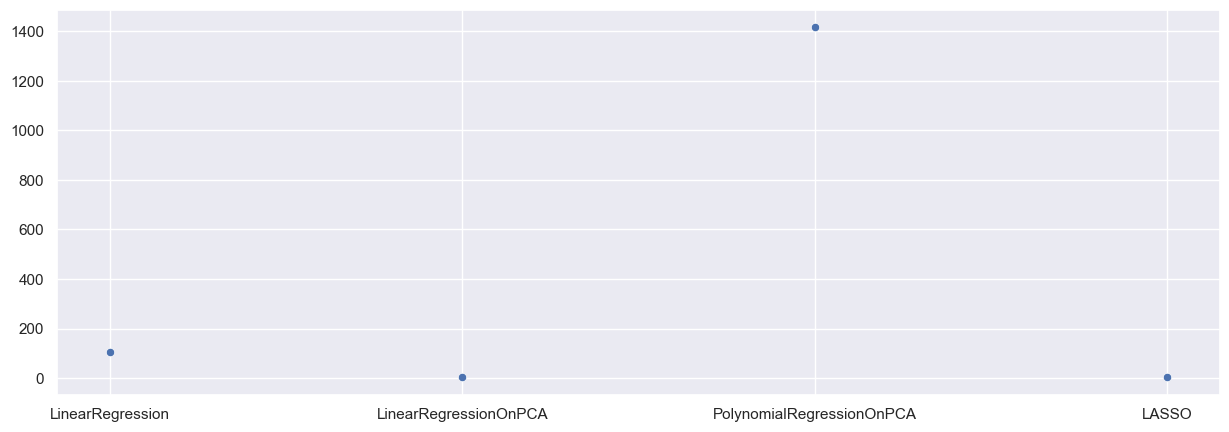

In [17]:
sns.scatterplot(nmses).figure.set_size_inches(15, 5)
plt.savefig("../Results/statistical_nmses.jpg", dpi=250)

In [18]:
def write_to_csv(name, nmses, times):
    content = ""
    for i in times:
        content += i + "," + str(nmses[i])[:7] + "," + str(times[i])[:7] + "," + str(nmses[i]*times[i])[:7] + "\n"
    print(content)
    with open(name, 'a') as f:
        f.write(content)
write_to_csv("../Results/results.csv", nmses, times)

LinearRegression,103.896,0.11873,12.3359
LinearRegressionOnPCA,3.38248,0.00283,0.00958
PolynomialRegressionOnPCA,1416.53,0.09206,130.416
LASSO,2.96192,0.00099,0.00295



## Example
We show an example of prediction from the test set.

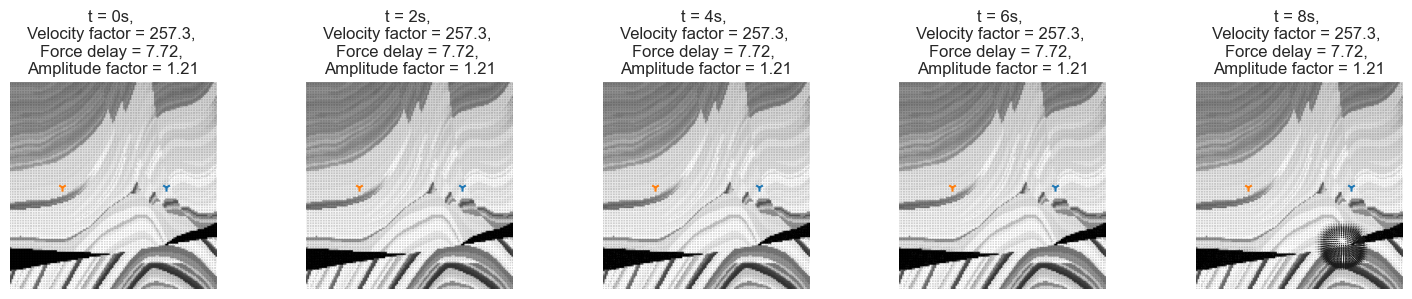

In [19]:
example_sample = 0
test.plot_item(example_sample)

In [20]:
print("Expected epicenter:", test[example_sample][0])
print("Predicted epicenter for each model:")
print("\t- Linear:\t\t", Y_hat["LinearRegression"][example_sample]*(test.nx/2))
print("\t- Linear on PCA:\t", Y_hat["LinearRegressionOnPCA"][example_sample]*(test.nx/2))
print("\t- Polynomial on PCA:\t", Y_hat["PolynomialRegressionOnPCA"][example_sample]*(test.nx/2))
print("\t- LASSO:\t\t", Y_hat["LASSO"][example_sample]*(test.nx/2))
#print("\t- Average:\t\t", Y_hat["Average"][example_sample]*(test.nx/2))

Expected epicenter: [27 38]
Predicted epicenter for each model:
	- Linear:		 [166.87798   11.970995]
	- Linear on PCA:	 [110.24024782 -36.99276079]
	- Polynomial on PCA:	 [279.14438293 -34.68880817]
	- LASSO:		 [ 98.70106858 -31.91706369]


## Conclusion
We see that averaging does not lead to better results. LASSO gives the best results in terms of mean absolute error.